In [1]:
from typing import List, Tuple
from abc import abstractmethod
import numpy as np
import torch as th
import matplotlib.pyplot as plt

In [2]:
from bandits import ContextualBandit, CrossSellBandit

# create a cross sell bandit with 100 articles (actions), 50 contexts each with a dimensionality of 10
bandit = CrossSellBandit(100, 50, 10)
# call reset to sample a new bandit, and get the context of the bandit.
# The next action should be a good action for this context
context = bandit.reset()

print('context = ', context)

# we can see an abstract embedding of the context
print('context embedding = ', bandit.get_context_embedding(context))

# similarly for the action
print('action embedding = ', bandit.get_action_embedding(0))

# now we can pull an arm, get a reward and a new context (independent of previous context or action)
context, reward = bandit.pull(0)

print('new context = ', context)
print('reward = ', reward)



context =  13
context embedding =  [ 1 -1 -1  1 -1  1  1  1 -1  1]
action embedding =  [-1 -1  1  1  1 -1  1 -1  1 -1]
new context =  23
reward =  -0.03850303482684336


In [3]:
class ContextualLearningRule(object):
    
    def __init__(self, num_arms: int, num_contexts: int, embedding_dim: int):
        self.embedding_dim = embedding_dim
        self.num_arms = num_arms
        self.num_contexts = num_contexts
        self.max_history_len = 500000
        self.pointer = 0
        self.history_size = 0
        self.context_history = np.zeros(self.max_history_len, dtype=int)
        self.action_history = np.zeros(self.max_history_len, dtype=int)
        self.reward_history = np.zeros(self.max_history_len, dtype=float)
            
    def reset(self) -> None:
        '''Forget the past experiences'''
        self.pointer = 0
        self.history_size = 0
        self.embedding_set = False
        self._reset()
    
    @abstractmethod
    def _reset(self) -> int:
        '''reset child class specific things'''
        
    def set_embedding(self, action_embeddings: np.ndarray, context_embeddings: np.ndarray) -> None:
        assert action_embeddings.shape[1] == self.embedding_dim
        assert context_embeddings.shape[1] == self.embedding_dim
        assert action_embeddings.shape[0] == self.num_arms
        assert context_embeddings.shape[0] == self.num_contexts
        self.action_embeddings  = th.tensor(action_embeddings, dtype=th.float)
        self.context_embeddings = th.tensor(context_embeddings, dtype=th.float)
    
    @abstractmethod
    def act(self, context: int) -> int:
        '''Determine which arm to pull next'''
    
    def update(self, context: int, action: int, reward: float) -> None:
        '''Save a context / action / reward triplet'''
        if action < 0 or action >= self.num_arms:
            raise ValueError("action must be be in the range [0, num_articles)")
        if context < 0 or context >= self.num_contexts:
            raise ValueError("context_article must be be in the range [0, num_articles)")
        self.context_history[self.pointer] = context
        self.action_history[self.pointer] = action
        self.reward_history[self.pointer] = reward
        self.pointer = (self.pointer + 1) % self.max_history_len
        self.history_size = min(self.history_size + 1, self.max_history_len)
        
class RandomLearningRule(ContextualLearningRule):
    
    def __init__(self, num_arms: int, num_contexts: int, embedding_dim: int):
        super(RandomLearningRule, self).__init__(num_arms, num_contexts, embedding_dim)
        self.rng = np.random.default_rng()
        
    def _reset(self) -> None:
        pass
    
    def act(self, context: int) -> int:
        return int(np.floor(self.num_arms * self.rng.random()))

    
def getContextualRecoMLP(action_dim: int,
                         context_dim: int,
                         hidden_dim: List[int],
                         output_dim: int):
    layer_list = [th.nn.Linear(context_dim + action_dim, hidden_dim[0])]
    all_dim = hidden_dim.copy()
    all_dim.append(output_dim)
    for i in range(len(all_dim)-1):
        layer_list.append(th.nn.ELU())
        layer_list.append(th.nn.Linear(all_dim[i], all_dim[i+1]))
    return th.nn.Sequential(*layer_list)

class EpsilonGreedyRule(ContextualLearningRule):
    
    def __init__(self,
                 num_arms: int,
                 num_contexts: int,
                 embedding_dim: int):
        super(EpsilonGreedyRule, self).__init__(num_arms, num_contexts, embedding_dim)
        self.epsilon = 0.05
        self.num_random_actions = 500
        self.batch_size = 128
        self.rng = np.random.default_rng()
        
    def _reset(self) -> None:
        self.learn_step = 0
        self.mlp = getContextualRecoMLP(self.embedding_dim, self.embedding_dim, [64, 64], 1)
        self.opti = th.optim.AdamW(self.mlp.parameters(), lr=0.0001, weight_decay=0.0001)
        
    def learn(self) -> None:
        '''Do one minibatch update'''
        self.opti.zero_grad()
        choice_index = self.rng.choice(self.history_size, size=self.batch_size)
        action_history_choice = th.tensor(self.action_history[choice_index], dtype=th.int)
        action_embedding  = th.index_select(self.action_embeddings, 0, action_history_choice)
        context_history_choice = th.tensor(self.context_history[choice_index], dtype=th.int)
        context_embedding = th.index_select(self.context_embeddings, 0, context_history_choice)
        reward = th.tensor(self.reward_history[choice_index])
        estimate = self.mlp(th.cat([context_embedding, action_embedding], dim=1))
        loss = th.mean(th.square(estimate.flatten() - reward))
        if False and self.learn_step % 20 == 0:
            print('i, loss = ', self.learn_step, loss.item())
        self.learn_step += 1
        loss.backward()
        self.opti.step()
        
    def act(self, context: int) -> int:
        # take a random action if we don't have much history or in epsilon percent of cases
        if self.history_size < self.num_random_actions or self.rng.random() < self.epsilon:
            return int(np.floor(self.num_arms * self.rng.random()))
        
        # update the model
        self.learn()
        
        # put all articles through the network, return the best one
        context_embedding = th.reshape(self.context_embeddings[context], (1, self.embedding_dim))
        context_embedding = th.tile(context_embedding, (self.num_arms, 1))
        return th.argmax(self.mlp(th.cat([context_embedding, self.action_embeddings], dim=1)).flatten()).item()
        
        

In [4]:
def evaluateLearningRule(learning_rule: ContextualLearningRule,
                         bandit: ContextualBandit,
                         horizon: int = 5000,
                         num_eval: int = 5,
                         bundle_factor = 10) -> Tuple[np.ndarray, np.ndarray]:
    '''Evaluate the performance of a learning rule on a class of bandits'''
    assert horizon % bundle_factor == 0 
    rng = np.random.default_rng(397428)
    regrets = np.zeros((num_eval, horizon))
    for i in range(num_eval):
        # seed the bandit and reset it (now arms are different)
        bandit.seed(rng.integers(0,high=2e8))
        context = bandit.reset()
        learning_rule.reset()
        learning_rule.set_embedding(bandit.get_all_action_embeddings(), bandit.get_all_context_embeddings())
        for j in range(horizon):
            action = learning_rule.act(context)
            regret = bandit.regret(action) # this function is for evaluation only
            context, reward = bandit.pull(action)
            learning_rule.update(context, action, reward)
            regrets[i,j] = regret
    regrets = np.reshape(regrets, (num_eval, horizon // bundle_factor, bundle_factor))
    regrets = np.mean(regrets, axis=2)
    return np.mean(regrets, axis=0), 2 * np.std(regrets, axis=0) / np.sqrt(num_eval)
            

In [5]:
class YourLearningRule(ContextualLearningRule):
    
    def __init__(self,
                 num_arms: int,
                 num_contexts: int,
                 embedding_dim: int):
        super(YourLearningRule, self).__init__(num_arms, num_contexts)
        
    def _reset(self) -> None:
        pass
        
    def act(self, context: int) -> int:
        '''
        TODO: write this function, use the history member variable 
        which maps from actions to the rewards collected by this action
        '''
        pass
        


average random regret =  1.9043206511847772
average epsilon greedy regret =  0.6355241704655596


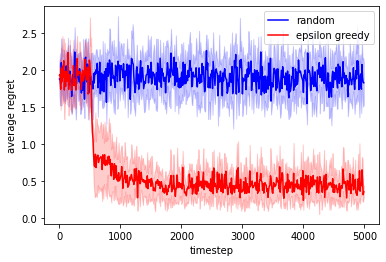

In [6]:
# report regrets and plot everything
NUM_ARMS = 100
NUM_CONTEXTS = 100
DIM = 20
bandit = CrossSellBandit(NUM_ARMS, NUM_CONTEXTS, DIM)

random_learning_rule = RandomLearningRule(NUM_ARMS, NUM_CONTEXTS, DIM)
regret_mean, regret_std = evaluateLearningRule(random_learning_rule, bandit)
print('average random regret = ', np.mean(regret_mean))
plt.plot(10 * np.arange(regret_mean.shape[0])+1, regret_mean, color='b', label='random')
plt.fill_between(10 * np.arange(regret_mean.shape[0]), regret_mean - regret_std, regret_mean + regret_std, color='b', alpha=0.2)

epsilon_greedy = EpsilonGreedyRule(NUM_ARMS, NUM_CONTEXTS, DIM)
#epsilon_greedy = EpsilonGreedyRule(NUM_ARMS, NUM_CONTEXTS, DIM)

regret_mean, regret_std = evaluateLearningRule(epsilon_greedy, bandit)
print('average epsilon greedy regret = ', np.mean(regret_mean))
plt.plot(10 * np.arange(regret_mean.shape[0])+1, regret_mean, color='r', label='epsilon greedy')
plt.fill_between(10 * np.arange(regret_mean.shape[0]), regret_mean - regret_std, regret_mean + regret_std, color='r', alpha=0.2)

plt.legend()
plt.ylabel('average regret')
plt.xlabel('timestep')
plt.show()